In [1]:
import argparse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time
from scipy import interp
from scipy.stats import fisher_exact
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc, roc_curve, confusion_matrix, make_scorer
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

import pickle 
import os, sys

src_dir = os.path.normpath(os.path.join(os.getcwd(), 'src/util'))
sys.path.insert(0, src_dir)

src_dir_model = os.path.normpath(os.path.join(os.getcwd(), 'Analysis_model'))
sys.path.insert(0, src_dir_model)

import FileIO as fio
import PCA_Analysis as pca
import RF_Analysis_Multiclass as rfc
import RF_Analysis_Binary as rfb
from util import collapse_taxonomic_contents_df 
import shap

In [2]:
datadir = "data/clean_tables"

dfdict = fio.read_dfdict_data(datadir)

schubert_data = dfdict["cdi_schubert"]
schubert_df = dfdict["cdi_schubert"]["df"]
schubert_meta = dfdict["cdi_schubert"]["meta"]

Reading datasets...
hiv_dinh
crc_baxter
crc_wang
asd_son
ibd_morgan
ibd_papa
hiv_noguerajulian
edd_singh
nash_wong
par_scheperjans
hiv_lozupone
ibd_gevers
cdi_vincent
crc_chen
ob_turnbaugh
t1d_mejialeon
ob_ross
noncdi_schubert
ob_zhu
crc_zeller
nash_zhu
cdi_schubert
asd_kang
cdi_youngster
ob_zupancic
liv_zhang
art_scher
ob_goodrich
t1d_alkanani
ibd_willing

Reading datasets... Finished.


# Clinical data

In [3]:
clinical_data = schubert_meta[["age", "race", "gender", "antibiotics >3mo", 
                                "antacid", "weight", 
                               "Healthworker", "historyCdiff", "Surgery6mos",
                               "Vegetarian", "ResidenceCdiff"]]
numeric = clinical_data["age"]
categorial = clinical_data[["race", "gender", "antibiotics >3mo", 
                                "antacid", "weight",
                               "Healthworker", "historyCdiff", "Surgery6mos",
                               "Vegetarian", "ResidenceCdiff"]]
categorial = pd.get_dummies(categorial)
clinical_features = pd.concat([numeric, categorial], axis=1)

disease_cdi = schubert_meta["DiseaseState"]

In [4]:
y = schubert_meta["DiseaseState"].apply(lambda x: 0 
                                          if x == "CDI" else 1
                                          if x == "ignore-nonCDI" else 2)

X_train, X_test, y_train, y_test = train_test_split(clinical_features, y, test_size=0.3, random_state=42)

### Random Forest for all variables 

****************************************************************************************************
Starting RandomSearchCV-RandomForest steps with f1_macro for evaluation rules...
****************************************************************************************************
----------------------------------------------------------------------------------------------------


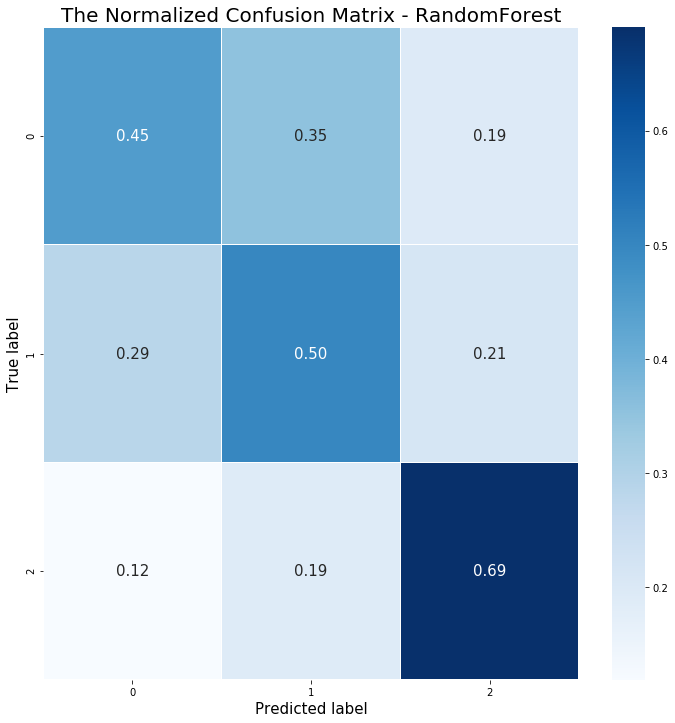


ROC curve and AUC


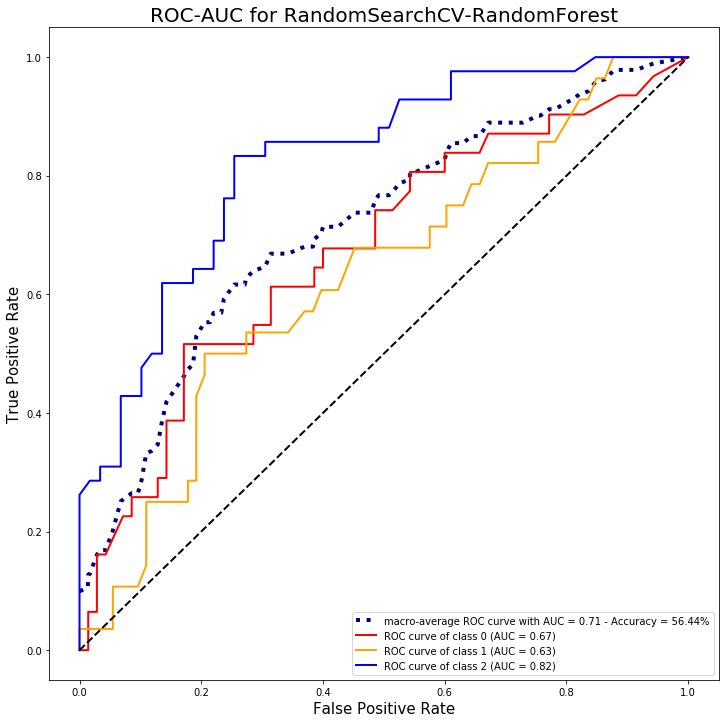

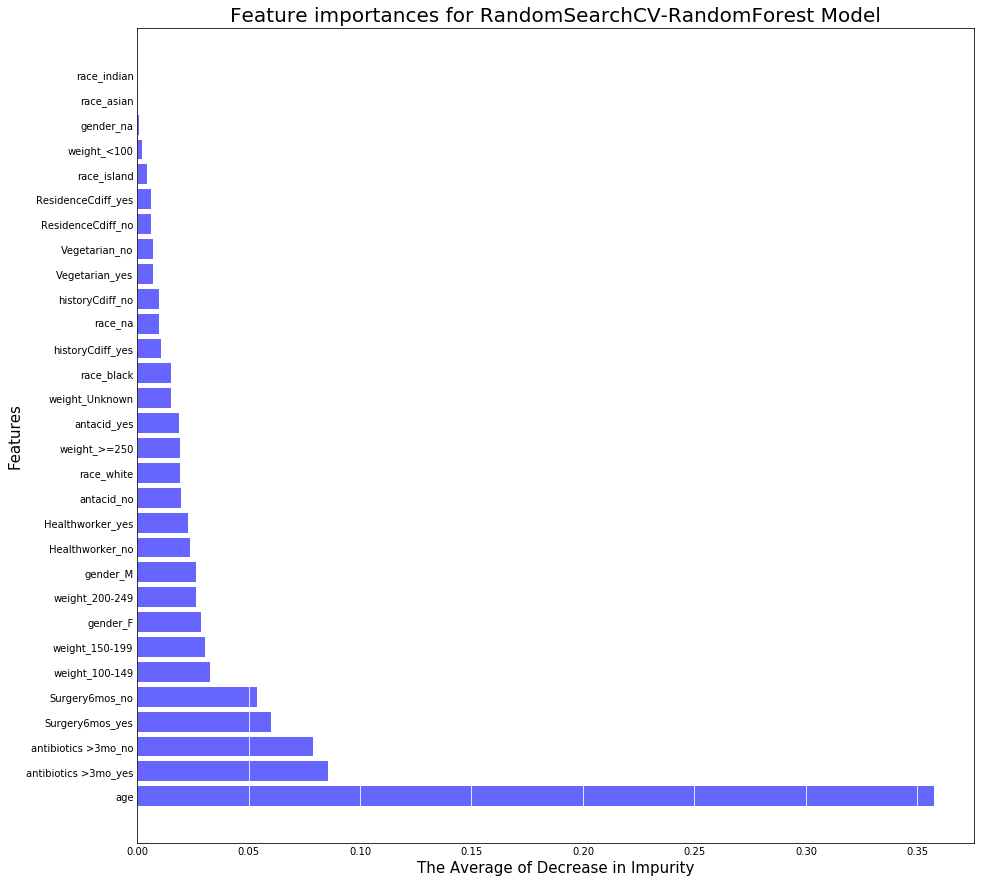

In [5]:
f = open("output.txt", "a")
results_cl = rfc.RF_classifier(X_train, y_train, X_test, y_test, "f1_macro", "RandomSearchCV-RandomForest", 
                               num_class = 3, output_file = f, top_feature = 30)
f.close()

### Random Forest + forward algorithm to select subset features 

In [6]:
all_info_grid, models_grid, all_features_grid = rfc.random_forest_forward(X_train, y_train, X_test, y_test, scoring='accuracy', 
                                                           n_selected_features = 30)

The current number of features: 1 - Accuracy: 58.42%
The current number of features: 2 - Accuracy: 59.41%
The current number of features: 3 - Accuracy: 59.41%
The current number of features: 4 - Accuracy: 60.4%
The current number of features: 5 - Accuracy: 63.37%
The current number of features: 6 - Accuracy: 63.37%
The current number of features: 7 - Accuracy: 63.37%
The current number of features: 8 - Accuracy: 63.37%
The current number of features: 9 - Accuracy: 63.37%
The current number of features: 10 - Accuracy: 61.39%
The current number of features: 11 - Accuracy: 62.38%
The current number of features: 12 - Accuracy: 61.39%
The current number of features: 13 - Accuracy: 61.39%
The current number of features: 14 - Accuracy: 61.39%
The current number of features: 15 - Accuracy: 61.39%
The current number of features: 16 - Accuracy: 61.39%
The current number of features: 17 - Accuracy: 61.39%
The current number of features: 18 - Accuracy: 61.39%
The current number of features: 19 - A

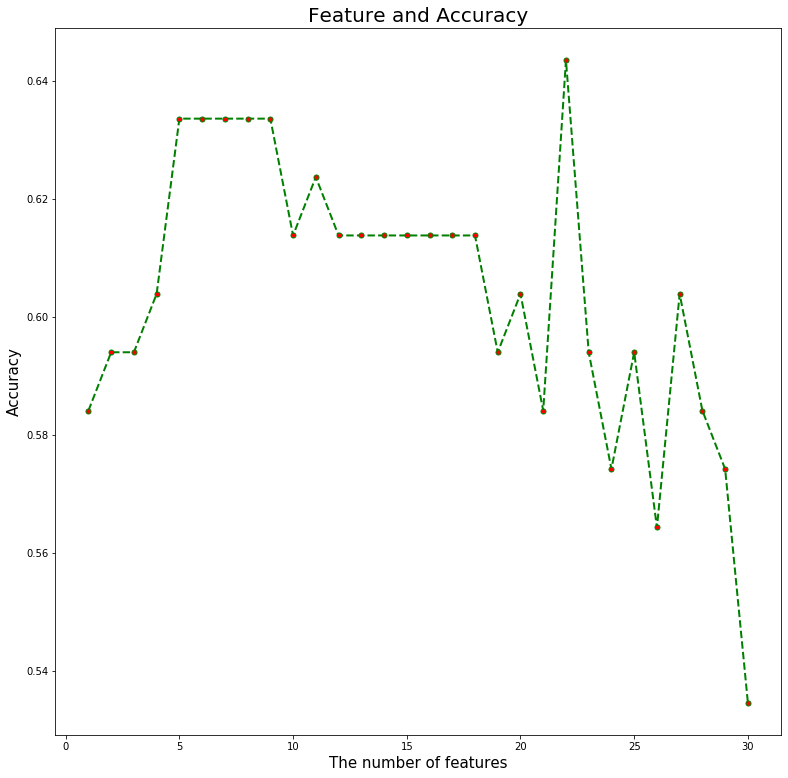

In [8]:
feature_acc = all_info_grid.sort_values(by="Num_feature")
plt.figure(figsize=(13,13))
plt.plot(feature_acc["Num_feature"], feature_acc["Accuracy"], color="green", linestyle="dashed",
        linewidth=2, marker="o", markerfacecolor="red", markersize=5)
plt.title("Feature and Accuracy", fontsize=20)
plt.xlabel("The number of features", fontsize=15)
plt.ylabel("Accuracy", fontsize=15)
plt.show()

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~ PERFORMANCE EVALUATION ~~~~~~~~~~~~~~~~~~~~~~~~
Detailed report for the Random Forest algorithm
The number of accurate predictions out of 101 data points on unseen data is 65
Accuracy of the Random Forest model on unseen data is 64.36
Precision of the Random Forest model on unseen data is 0.6313
Recall of the Random Forest model on unseen data is 0.6244
F1 score of the Random Forest model on unseen data is 0.6248

Classification report for Random Forest model: 

              precision    recall  f1-score   support

           0       0.64      0.52      0.57        31
           1       0.55      0.57      0.56        28
           2       0.70      0.79      0.74        42

    accuracy                           0.64       101
   macro avg       0.63      0.62      0.62       101
weighted avg       0.64      0.64      0.64       101


The Confusion Matrix: 

[[16  8

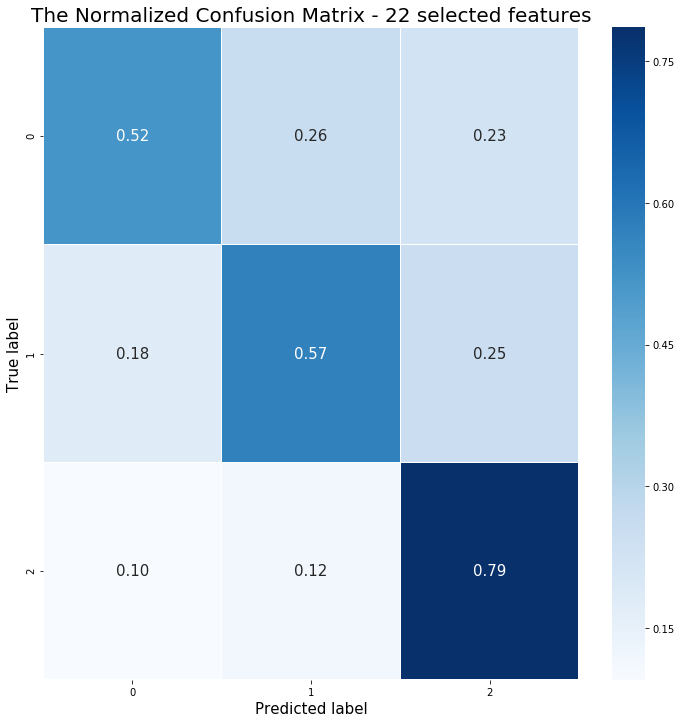


ROC curve and AUC


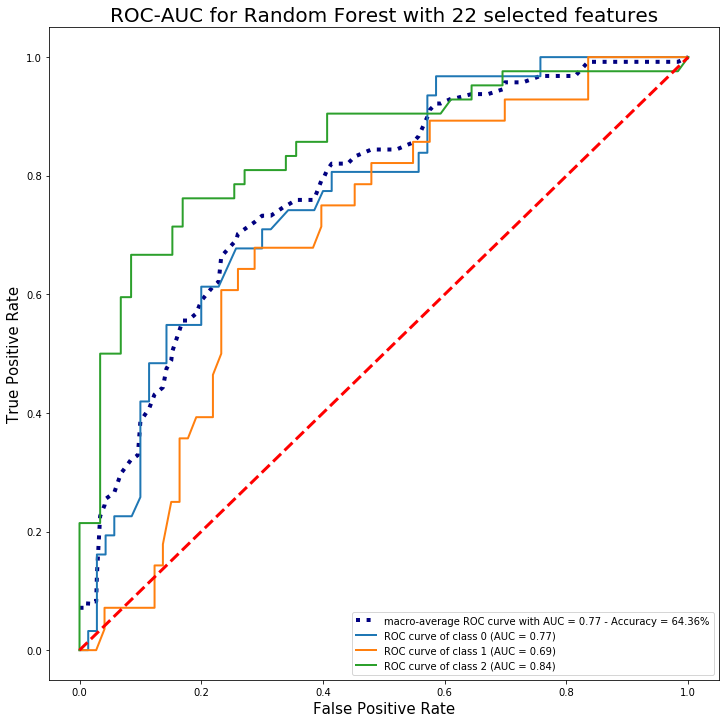

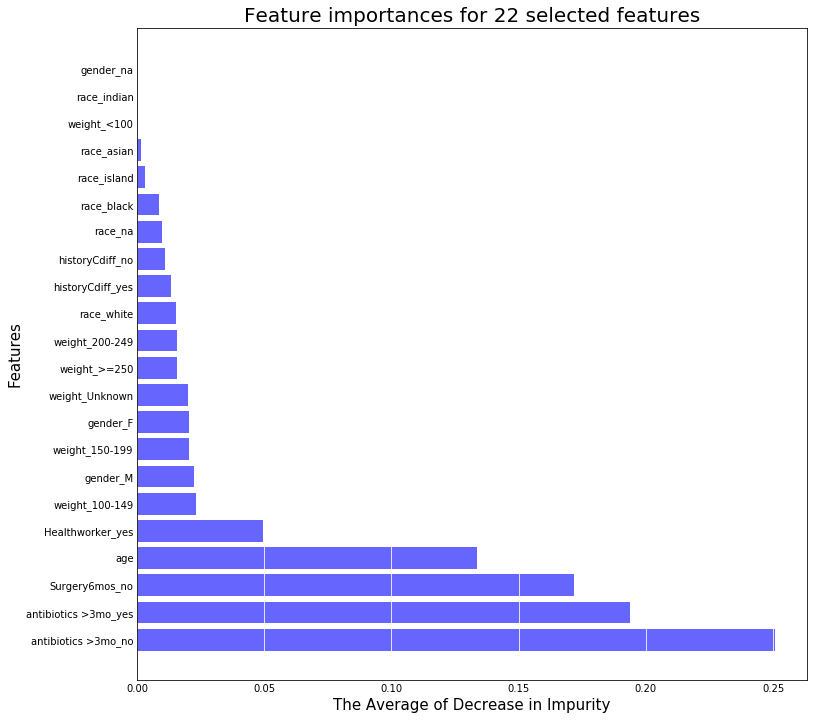

In [10]:
best_model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features="log2", max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=8,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

subset = all_features_grid.drop(columns = ["All"])
subset = subset.iloc[21].dropna()
X_train, X_test, y_train, y_test = train_test_split(clinical_features[subset], y, test_size=0.3, 
                                                    random_state=42)
result_22 = rfc.evaluate_multiclass(best_model, X_train, y_train, X_test, y_test,
        model = "Random Forest", num_class=3, top_features=22, n_selected_features = 22)

In [13]:
best_model.fit(X_train, y_train)
explainer = shap.KernelExplainer(best_model.predict_proba, X_train, link="logit")
shap_values = explainer.shap_values(X_test)

Using 235 background data samples could cause slower run times. Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.


In [17]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:],X_test.iloc[0,:], link="logit")

In [18]:
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test, link="logit")

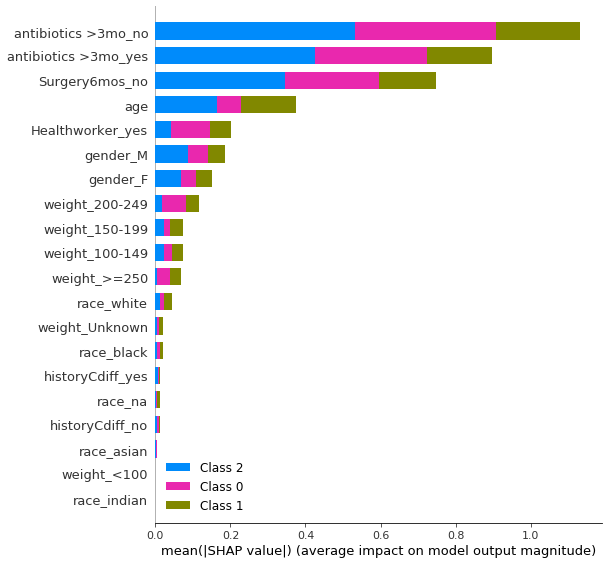

In [19]:
shap.summary_plot(shap_values, X_test)

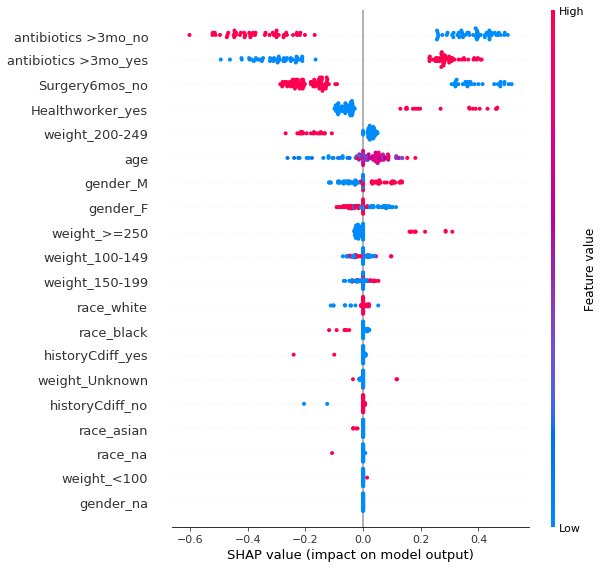

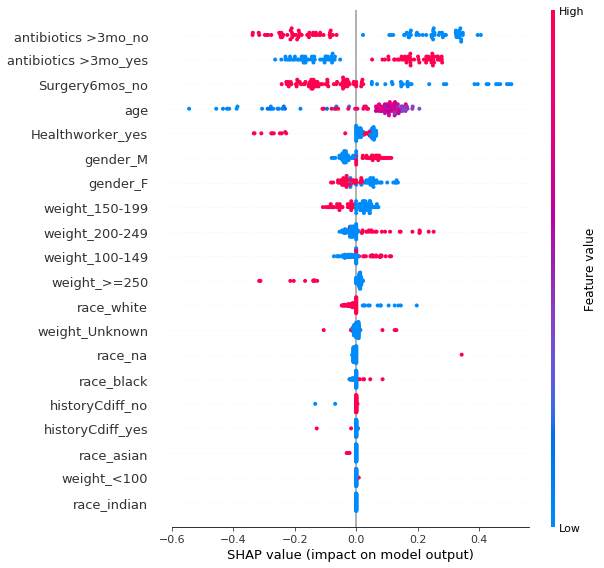

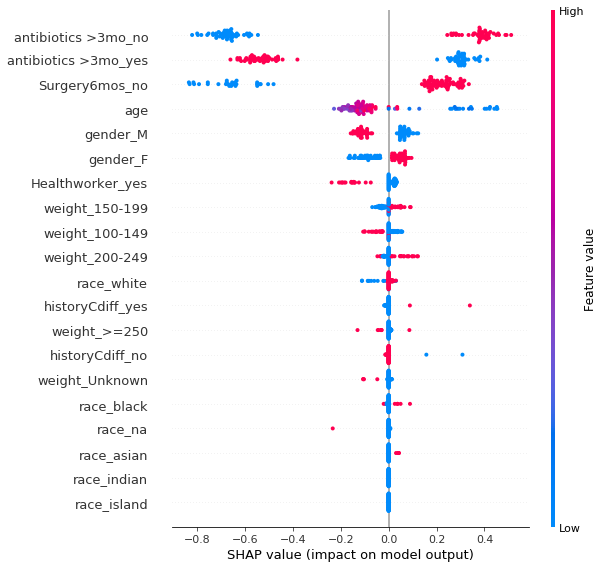

In [20]:
shap.summary_plot(shap_values[0], X_test)
shap.summary_plot(shap_values[1], X_test)
shap.summary_plot(shap_values[2], X_test)

# Microbiome data 

In [21]:
microbiome = schubert_df 
y = schubert_meta["DiseaseState"]
y = schubert_meta["DiseaseState"].apply(lambda x: 0 
                                          if x == "CDI" else 1
                                          if x == "ignore-nonCDI" else 2)
X_train, X_test, y_train, y_test = train_test_split(microbiome, y, test_size=0.3, random_state=42)

### Random Forest for all variables  

****************************************************************************************************
Starting RandomSearchCV-RandomForest steps with f1_macro for evaluation rules...
****************************************************************************************************
----------------------------------------------------------------------------------------------------


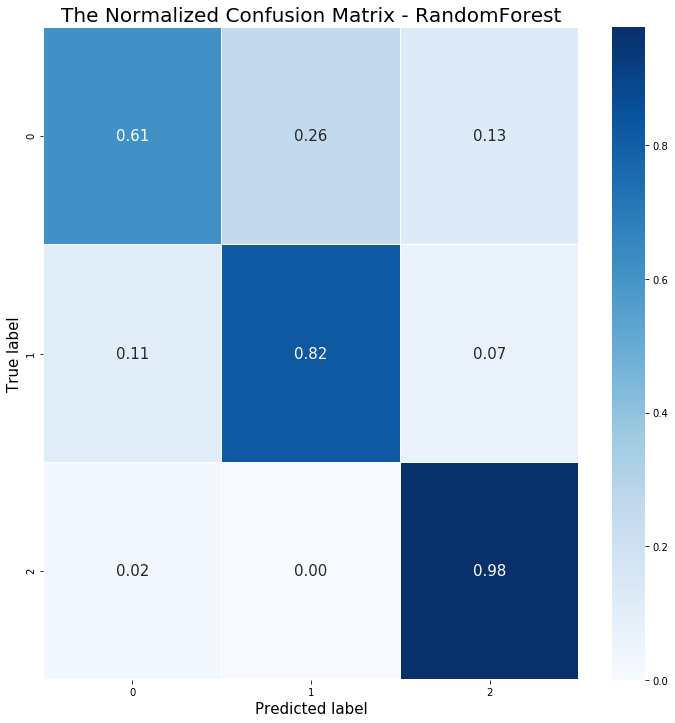


ROC curve and AUC


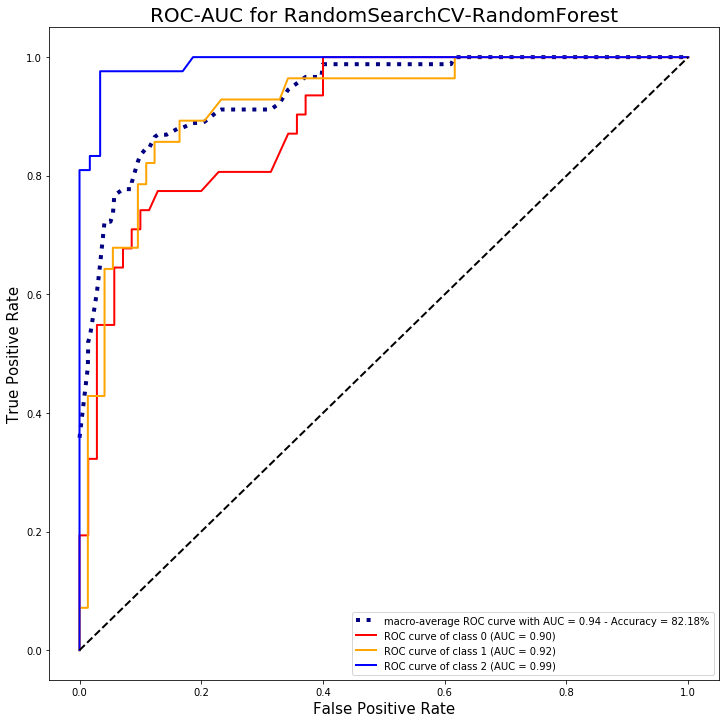

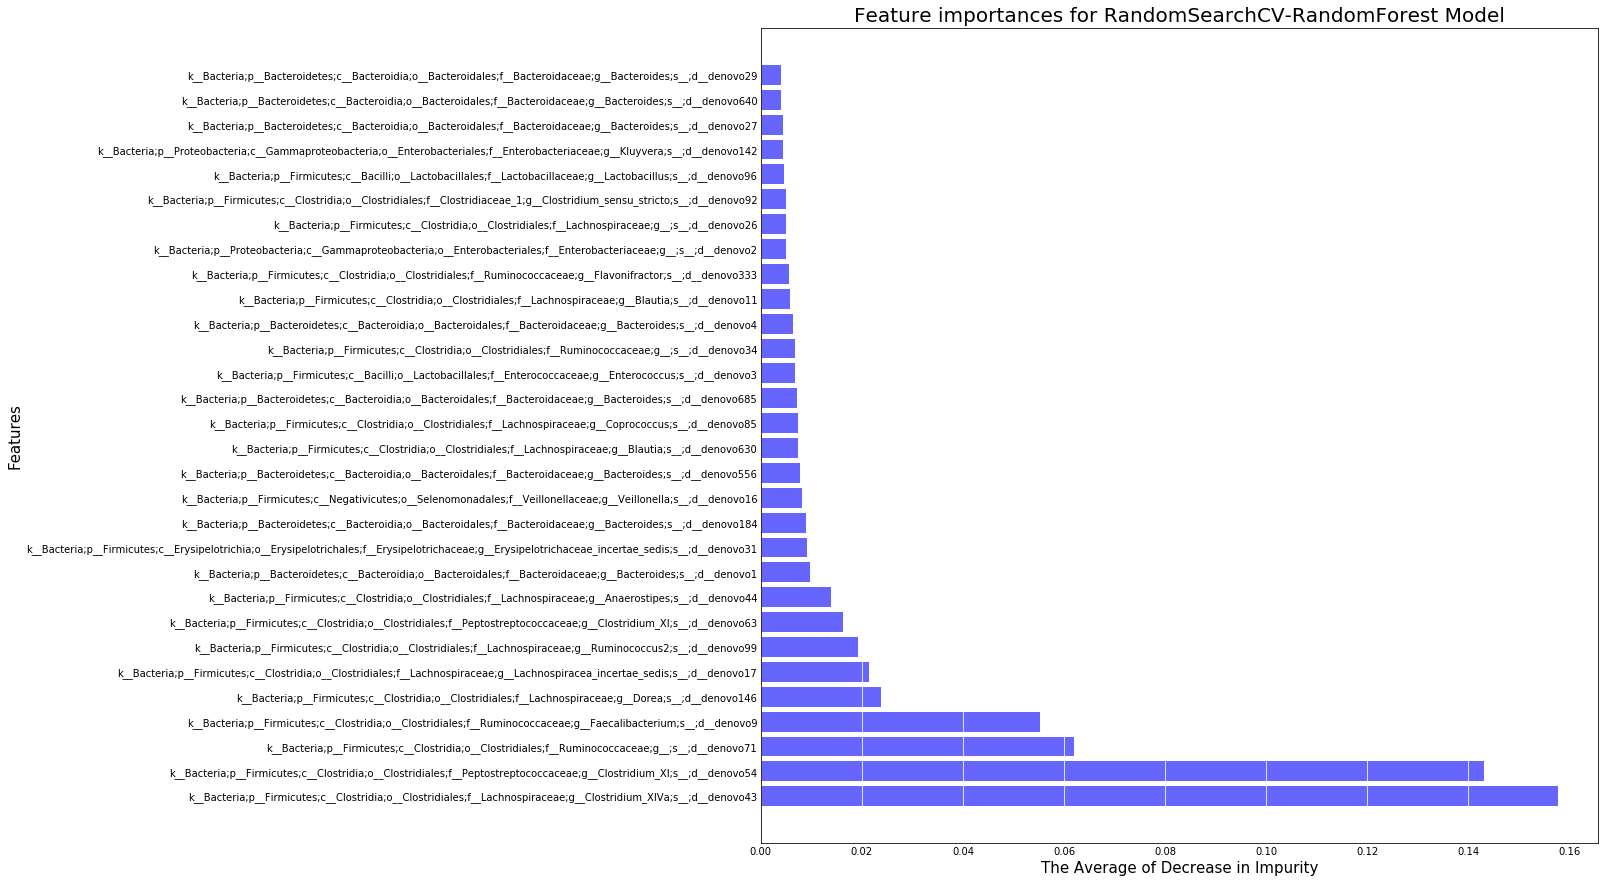

In [22]:
f = open("output.txt", "a")
results_cl = rfc.RF_classifier(X_train, y_train, X_test, y_test, "f1_macro", "RandomSearchCV-RandomForest", 
                               num_class = 3, output_file = f, top_feature = 30)
f.close()

### Random Forest + forward algorithm to select subset variables

In [23]:
all_features_grid = pd.read_csv("Disease_CDI/Microbiome_subset_200.csv")
all_info_grid = pd.read_csv("Disease_CDI/Microbiome_subset_accuracy_200.csv")
with open("Disease_CDI/Microbiome_model_200.txt", "rb") as fp:
    load_grid_model = pickle.load(fp)
subset = all_features_grid.drop(columns = ["Unnamed: 0", "All"])

In [27]:
all_info_grid.head(20)

,Num_feature,Accuracy,Feature
0,119,0.960396,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...
1,143,0.960396,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...
2,110,0.960396,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...
3,117,0.960396,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...
4,131,0.960396,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...
5,135,0.960396,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...
6,137,0.960396,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...
7,138,0.960396,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...
8,139,0.960396,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...
9,140,0.960396,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...


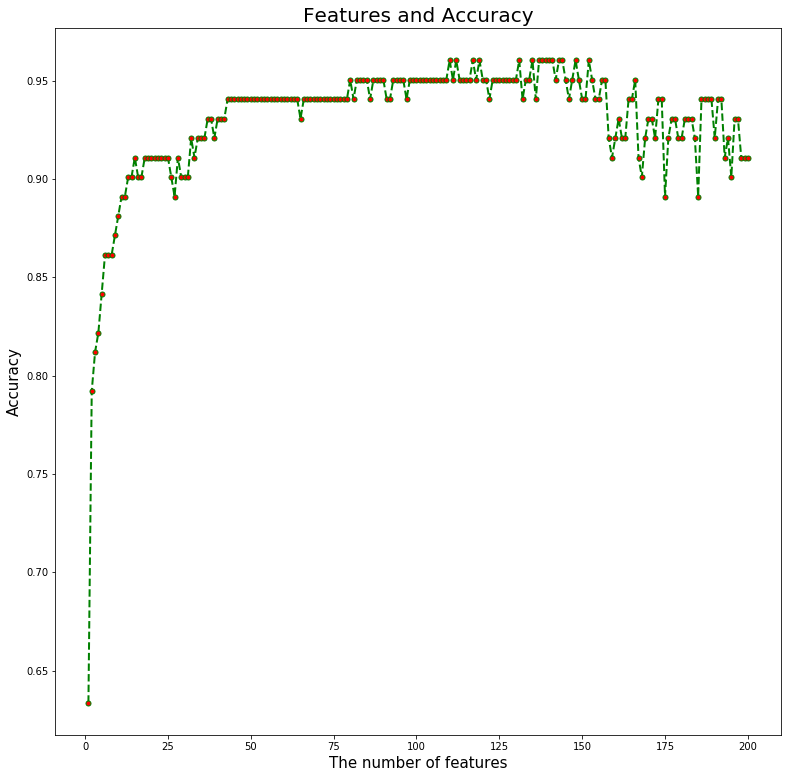

In [25]:
feature_acc = all_info_grid.sort_values(by="Num_feature")
plt.figure(figsize=(13,13))
plt.plot(feature_acc["Num_feature"], feature_acc["Accuracy"], color="green", linestyle="dashed", linewidth=2, marker="o",
         markerfacecolor="red", markersize=5)
plt.title("Features and Accuracy", fontsize=20)
plt.xlabel("The number of features", fontsize=15)
plt.ylabel("Accuracy", fontsize=15)
plt.show()

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~ PERFORMANCE EVALUATION ~~~~~~~~~~~~~~~~~~~~~~~~
Detailed report for the Random Forest algorithm
The number of accurate predictions out of 101 data points on unseen data is 97
Accuracy of the Random Forest model on unseen data is 96.04
Precision of the Random Forest model on unseen data is 0.9667
Recall of the Random Forest model on unseen data is 0.9547
F1 score of the Random Forest model on unseen data is 0.9598

Classification report for Random Forest model: 

              precision    recall  f1-score   support

           0       0.97      0.94      0.95        31
           1       1.00      0.93      0.96        28
           2       0.93      1.00      0.97        42

    accuracy                           0.96       101
   macro avg       0.97      0.95      0.96       101
weighted avg       0.96      0.96      0.96       101


The Confusion Matrix: 

[[29  0

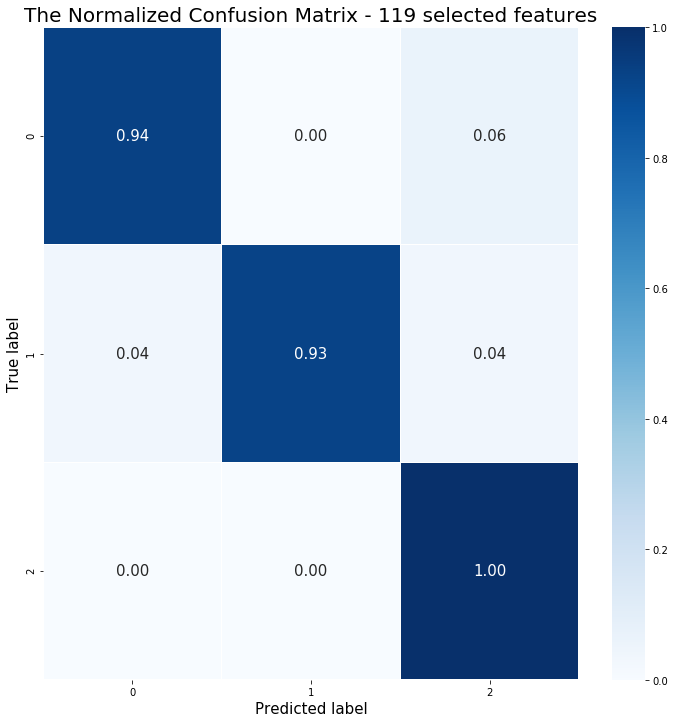


ROC curve and AUC


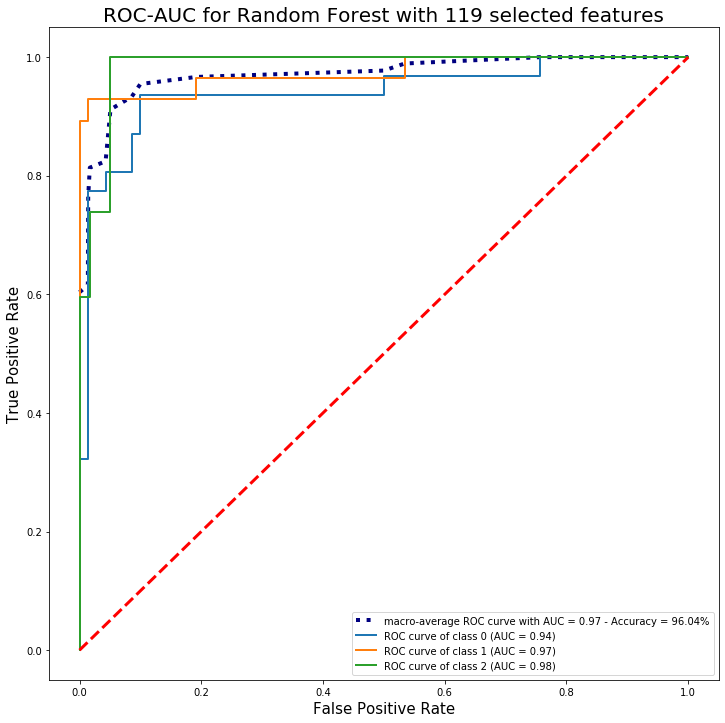

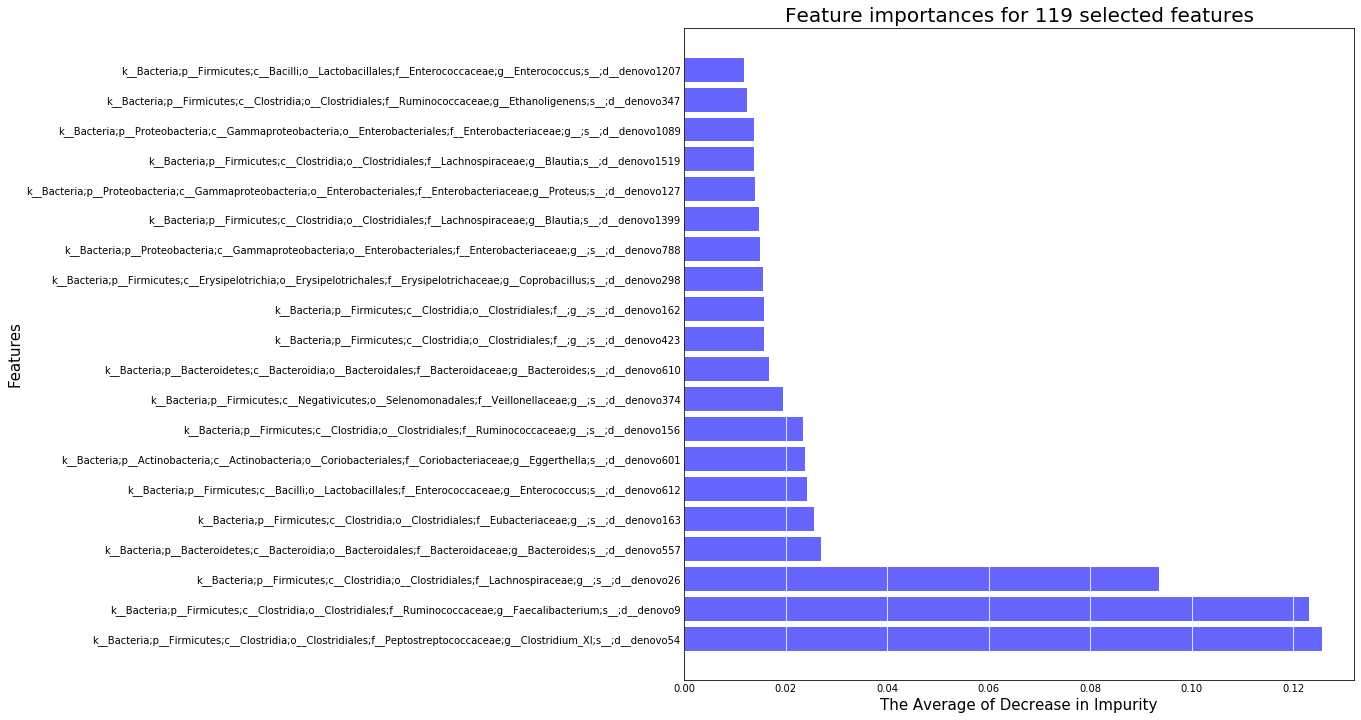

In [28]:
best_model_119 = load_grid_model[118]
subset = subset.iloc[118].dropna()
X_train, X_test, y_train, y_test = train_test_split(microbiome[subset], y, test_size=0.3, random_state=42)

result_119 = rfc.evaluate_multiclass(best_model_119, X_train, y_train, X_test, y_test,
        model = "Random Forest", num_class=3, top_features=20, n_selected_features = 119)